# **Tech Challenge 2 - Previsão Ibovespa**

Execute o comando abaixo para as instalações necessárias para o funcionamento do Notebook

In [421]:
!pip install -r requirements.txt

  Using cached prophet-1.2.1-py3-none-win_amd64.whl (12.1 MB)


ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: 'C:\\Users\\PEDRO\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python38\\site-packages\\prophet\\stan_model\\cmdstan-2.37.0\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_deprecated_header_message_guard.h'

You should consider upgrading via the 'C:\Users\PEDRO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# **1. Importações**

In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

## **2. Carregamento dos Dados (CSV)**

Arquivo extraído do site https://br.investing.com/indices/bovespa-historical-data com dados diários do Ibovespa.

Datas extraídas:
**24.10.2005 - 24.10.2025**

In [423]:
# Salvando dados do Ibovespa em um Dataframe
path = "data/dados_ibovespa.csv"

df = pd.read_csv(path)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,24.10.2025,146.172,145.721,147.240,145.721,"6,49B","0,31%"
1,23.10.2025,145.721,144.881,146.358,144.881,"6,60B","0,59%"
2,22.10.2025,144.873,144.094,145.048,144.039,"7,02B","0,55%"
3,21.10.2025,144.085,144.509,144.795,143.829,"6,19B","-0,29%"
4,20.10.2025,144.509,143.399,145.216,143.396,"6,79B","0,77%"


In [424]:
df.count()

Data        4957
Último      4957
Abertura    4957
Máxima      4957
Mínima      4957
Vol.        4956
Var%        4957
dtype: int64

O Dataframe que será analisado possui 4957 registros.

## **3. Pré-Processamento dos Dados**

In [425]:
# Verificando se há valores nulos no DataFrame
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Foi encontrado um valor nulo na coluna Volume (Vol.)
O valor será removido do dataframe, visando não atrapalhar o treinamento do modelo.

Como o Dataframe possui quase 5 mil linhas, essa deleção não terá impacto.

In [426]:
# Removendo o registro nulo

df = df.dropna()
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [427]:
# Setando a Coluna 'Data' como índice do Dataframe

df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values('Data')
df.set_index('Data', inplace=True)

## **4. Análise Exploratória**

### **Visualizando Série Histórica da Fechamento**

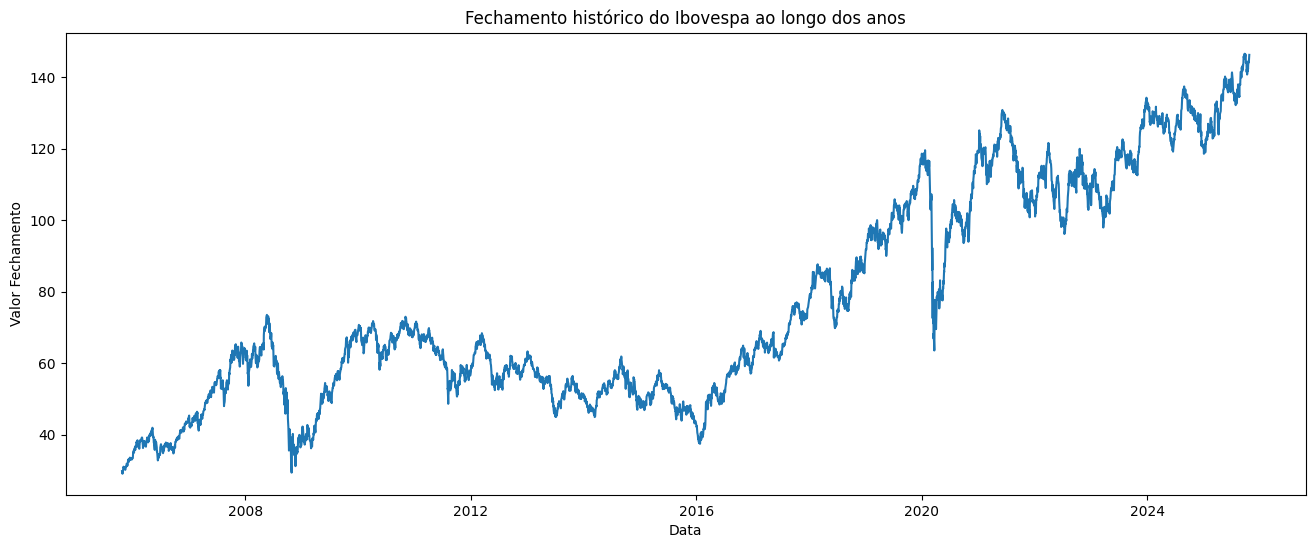

In [428]:
# Verificando a evolução histórica do fechamento do Ibovespa

plt.figure(figsize=(16,6))
plt.plot(df['Último']) # Coluna do Dataframe que representa o fechamento do dia 
plt.xlabel('Data')
plt.ylabel('Valor Fechamento')
plt.title('Fechamento histórico do Ibovespa ao longo dos anos')
plt.show()

### **Distribuições das Colunas de Preço**

(Abertura, Último, Mínima, Máxima)

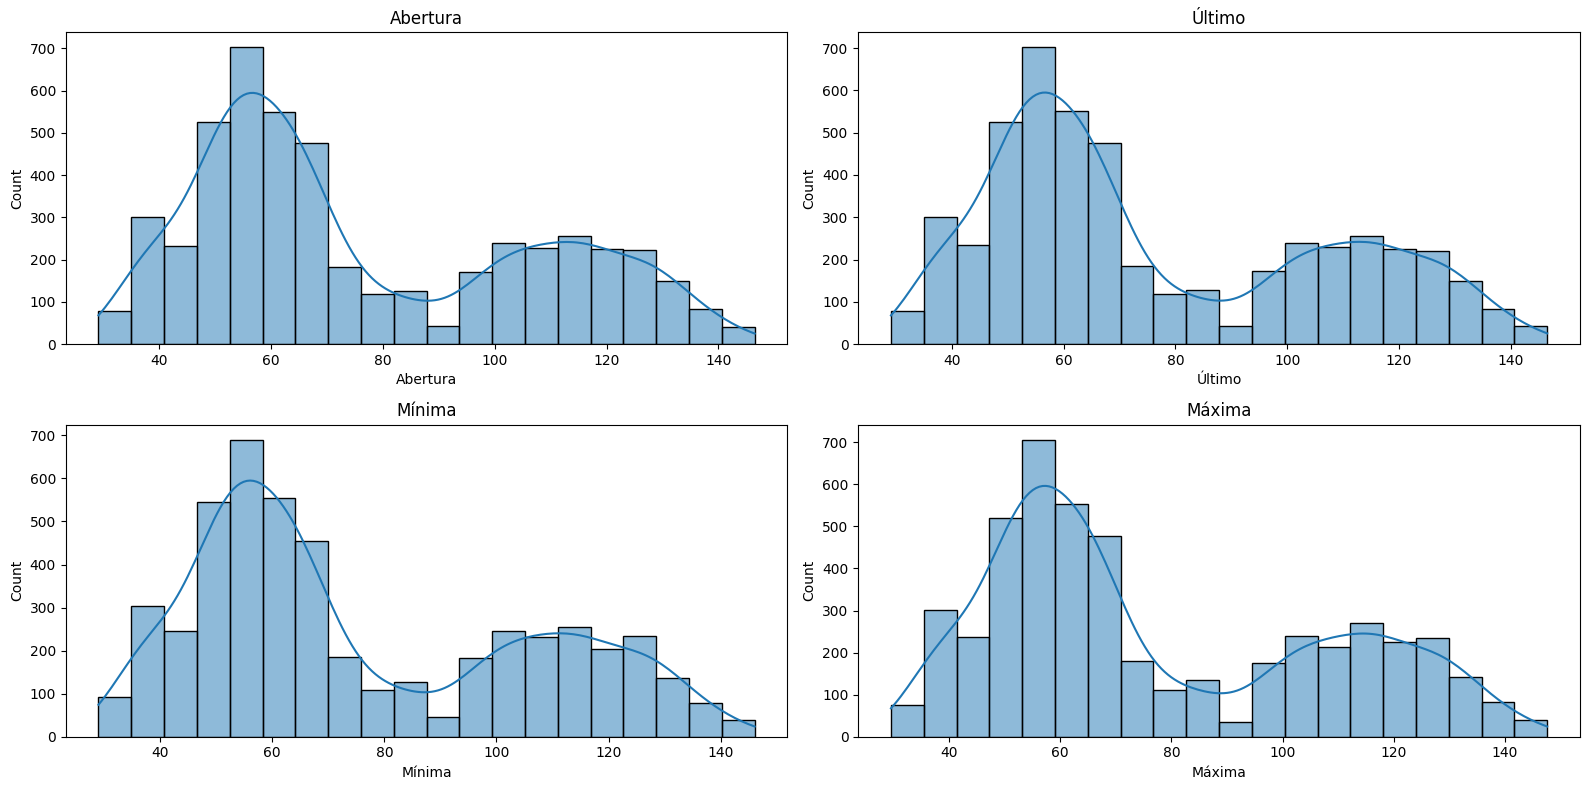

In [429]:
# Verificando as Distribuições das Variáveis do Dataframe

fig, axes = plt.subplots(2,2, figsize=(16,8))
axes = axes.flatten()

for i,col in enumerate(['Abertura','Último','Mínima','Máxima']): # Colunas do Dataframe do Ibovespa
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### **Série Temporal**

Visando entender o comportamento dos dados, realizo uma decomposição com o período de 252 dias, que é o tempo médio de um ano, descontando finais de semana e feriados.  

In [430]:
# Decompondo os valores em série temporal

ibov_seasonal = seasonal_decompose(df['Último'],period=252)

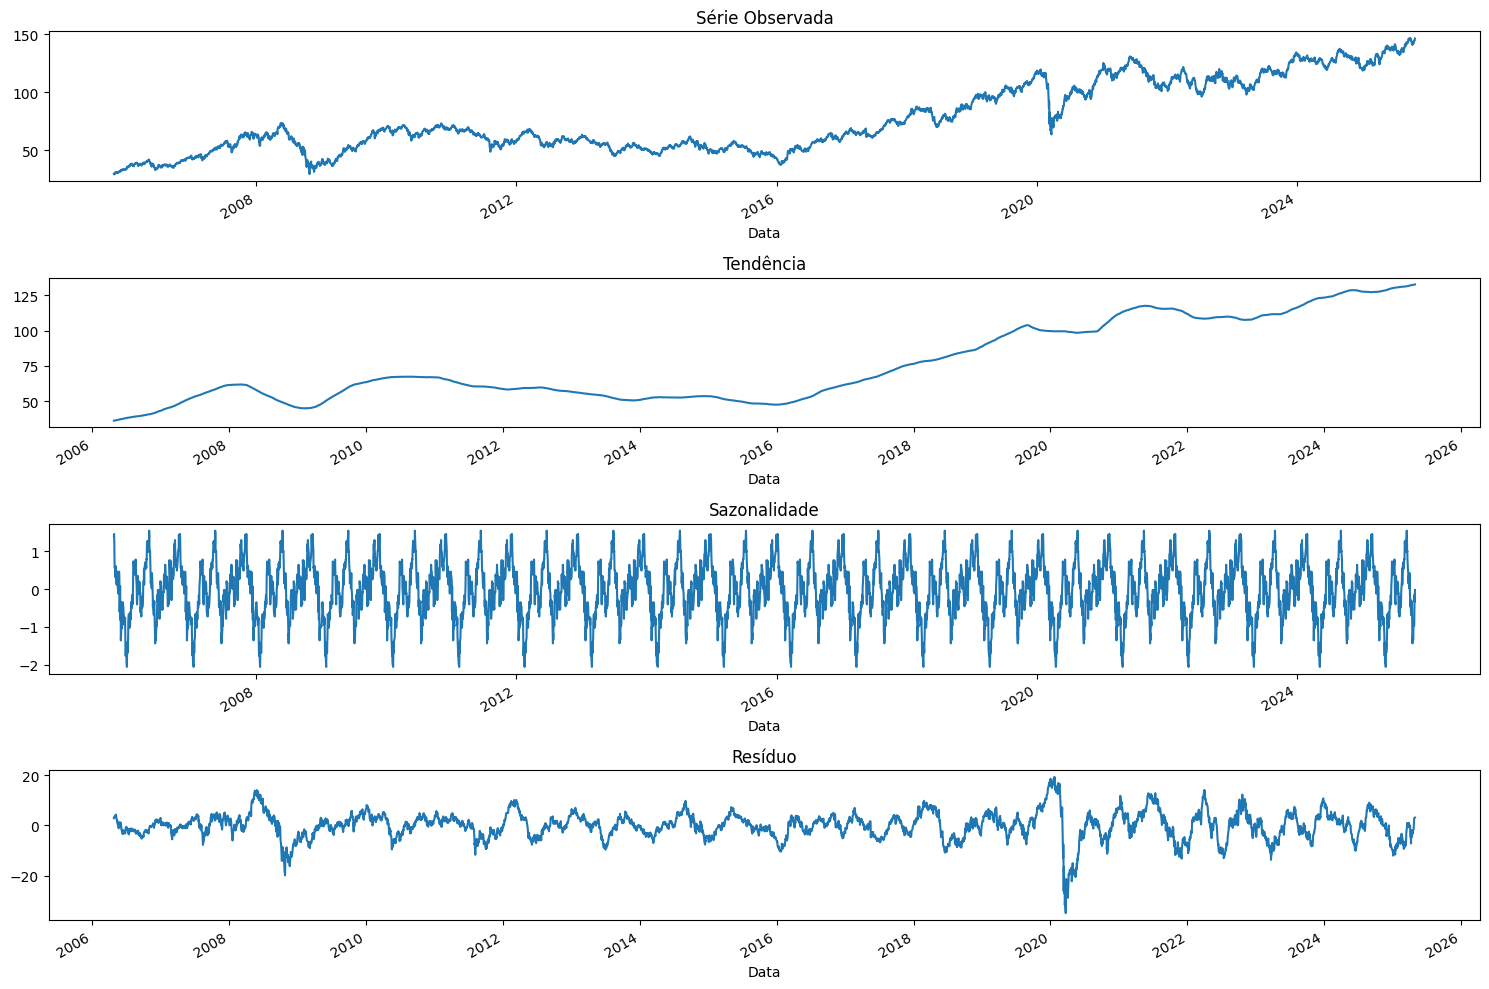

In [431]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))

ibov_seasonal.observed.plot(ax=ax1)
ax1.set_title("Série Observada")

ibov_seasonal.trend.plot(ax=ax2)
ax2.set_title("Tendência")

ibov_seasonal.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

ibov_seasonal.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()

plt.show()

**Resultados obtidos:**

- Apesar de alguns períodos de queda, como 2008/2009 e 2020/2021, a série demonstrou uma tendência de crescimento a longo prazo.
- Analisando ano a ano, é possível observar um padrão sazonal que se repete de forma consistente.
- O maior desvio observado foi em 2020, devido a pandemia.

**Próximo Passo:**
- Realizar Teste de Estacionaridade de Dickey-Fuller

In [432]:
# Realizando teste de Estacionariedade — ADF

x_ibov = df['Último'].values

resultados_ibov = adfuller(x_ibov)

print("Teste ADF")
print(f"Teste Estatístico : {resultados_ibov[0]}")
print(f"P - Value : {resultados_ibov[1]}")
print("Valores Criticos:")

for key,value in resultados_ibov[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico : -0.7568139970586006
P - Value : 0.8314797691577929
Valores Criticos:
	1%:-3.4316725584017265
	5%:-2.8621244264217403
	10%:-2.5670810911297512


O que já era possível de observar, se concretizou com o Teste ADF: A série não é estacionária.

### **Média Móvel e Desvio Padrão**

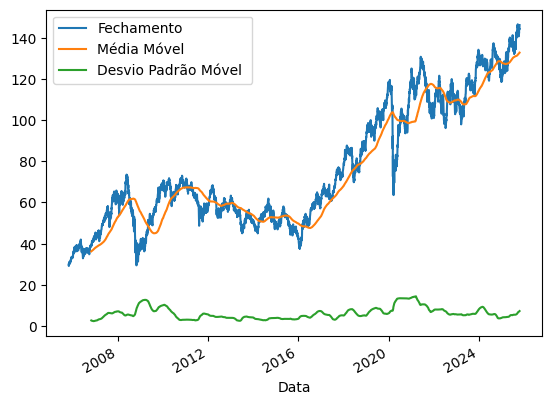

In [433]:
# Gráfico com a Média Móvel e Desvio Padrão do Fechamento

ax = df['Último'].plot(label="Fechamento")
df['Último'].rolling(window=252).mean().plot(ax=ax, label="Média Móvel ") 
df['Último'].rolling(window=252).std().plot(ax=ax, label="Desvio Padrão Móvel ")
ax.legend()
plt.show()

**Resultados Obtidos:**

- O gráfico demonstra uma média móvel com variações, demosntrando tendências. 
- O desvio padrão móvel sofre diversas variações. E é possível obervar a maior expressão em 2020/2021, novamente devido a pandemia.

**Próximos Passos:**

- Aplicar diff (diferenciação)
- Estabilizar a média e a variância da série
- Preparar os dados para modelos preditivos.


In [434]:
# Aplicando a diferenciação

# df = df['Último'].diff().dropna()
# df_diff = df.copy().drop(columns=['Último'])
# df_diff['Último'] = df.dropna() 

df_2 = df['Último'].diff().dropna()
df_diff = df.copy().drop(columns=['Último'])
df_diff['Último'] = df_2.dropna() # Armazenando em uma nova variável - df_diff (já com a aplicação da diferenciação)

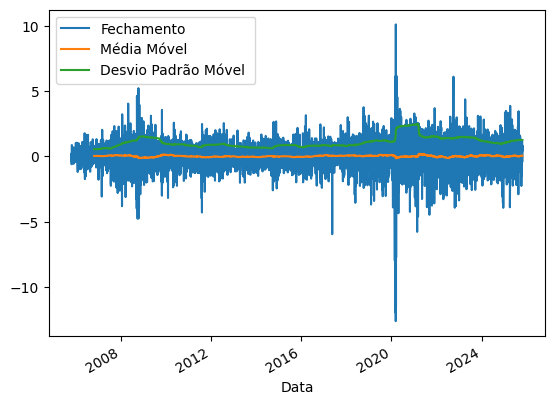

In [435]:
# Novo gráfico com a Média Móvel e Desvio Padrão do Fechamento
# Dessa vez com o df_diff (Dataframe com a aplicação da diferenciação)

ax = df_diff['Último'].plot(label="Fechamento")
df_diff['Último'].rolling(window=252).mean().plot(ax=ax, label="Média Móvel ")
df_diff['Último'].rolling(window=252).std().plot(ax=ax, label="Desvio Padrão Móvel ")
ax.legend()
plt.show()

In [436]:
# Realizando um novo teste de Estacionariedade — ADF
# Dessa vez com o df_diff (Dataframe com a aplicação da diferenciação)

x_ibov_diff = df_diff['Último'].dropna().values

resultados_ibov_diff = adfuller(x_ibov_diff)

print("Teste ADF")
print(f"Teste Estatístico : {resultados_ibov_diff[0]}")
print(f"P - Value : {resultados_ibov_diff[1]}")
print("Valores Criticos:")

for key,value in resultados_ibov_diff[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico : -23.885942592814917
P - Value : 0.0
Valores Criticos:
	1%:-3.4316725584017265
	5%:-2.8621244264217403
	10%:-2.5670810911297512


### Autocorrelação (ACF)

In [437]:
# Convertendo a coluna 'Último' para numérico, tratando valores inválidos e removendo nulos.

serie_ibov = pd.to_numeric(df_diff['Último'], errors='coerce').dropna()

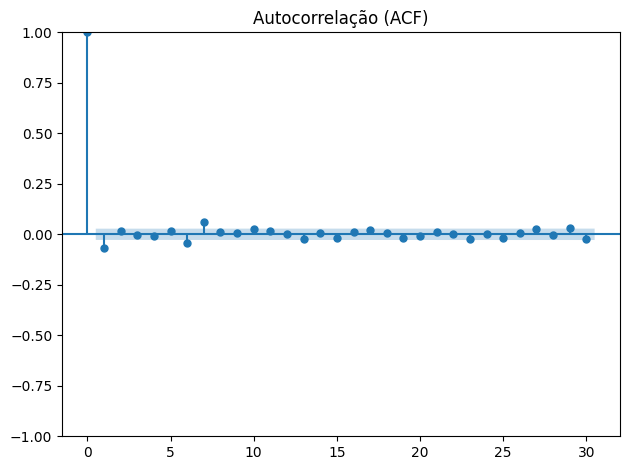

In [438]:
plot_acf(serie_ibov, lags=30)
plt.title("Autocorrelação (ACF)")
plt.tight_layout()
plt.show()

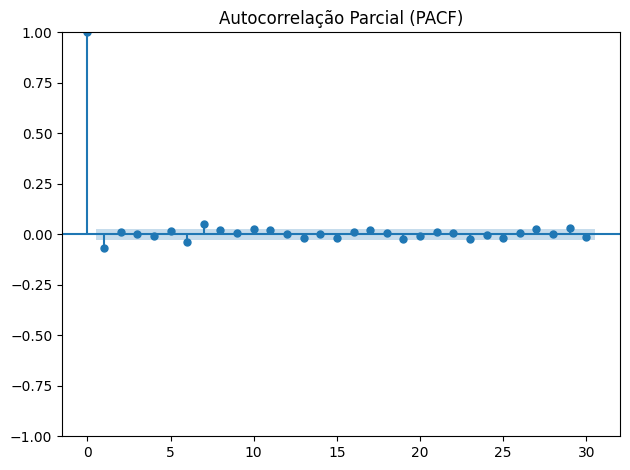

In [439]:
plot_pacf(serie_ibov, lags=30)
plt.title("Autocorrelação Parcial (PACF)")
plt.tight_layout()
plt.show()

In [440]:
# Definindo um intervalo de lags de 1 a 9 dias
lags = range(1, 10)
autocorrelacoes = [serie_ibov.autocorr(lag) for lag in lags]

Cada lag representa quantos dias no passado a série será comparada com o valor atual.

In [441]:
# DataFrame relacionando cada lag com sua respectiva autocorrelação
df_lags = pd.DataFrame({
    'Lag': lags,
    'Autocorrelacao': autocorrelacoes
})


# Calculando o valor absoluto da autocorrelação
df_lags['Abs_corr'] = df_lags['Autocorrelacao'].abs()

# Ordenando os lags mais relevantes (por valor absoluto, decrescente)
df_lags = df_lags.sort_values('Abs_corr', ascending=False)

In [442]:
# Visualizando os lags mais relevantes

df_lags.head()

,Lag,Autocorrelacao,Abs_corr
0,1,-0.069844,0.069844
6,7,0.058870,0.058870
5,6,-0.042275,0.042275
1,2,0.018560,0.018560
4,5,0.016798,0.016798


**Resultados obtidos**

- Alguns lags que apresentam correlação significativa com o valor atual. Eles podem ser utilizados como variáveis preditoras na construção do modelo. 
- ?A principio deixei os 5 primeiros para verificação

## **5. Definição do Target**

In [443]:
# Criando um novo DataFrame

df_ibov = pd.DataFrame()

In [444]:
# Calculando a variação percentual do fechamento de dois dias consecutivos

df_ibov['Fechamento'] = df_diff['Último']
df_ibov['Delta'] = df_ibov['Fechamento'].pct_change(periods=1).shift(-1)

df_ibov.head()

,Fechamento,Delta
Data,,
2005-10-24,NaN,NaN
2005-10-25,-0.337,-1.688427
2005-10-26,0.232,-3.573276
2005-10-27,-0.597,-1.309883
2005-10-28,0.185,3.735135


Próximos passo é verificar qual o melhor Threshold para utilizar no calculo do Target


In [445]:
# Verificando qual Threshold utilizar para o calculo do meu target

for t in [0.0025, 0.005, 0.0075, 0.01]:
    y_temp = np.where(df_ibov['Delta'] > t, 1, np.where(df_ibov['Delta'] < -t, 0, np.nan))
    total = len(y_temp[~np.isnan(y_temp)]) # Calculando o total de observações válidas
    pct_classe_1 = np.sum(y_temp == 1) / total * 100 # Alta (1)
    pct_classe_0 = np.sum(y_temp == 0) / total * 100 # Queda (0)
    print(f"Threshold: {t*100:.2f}% → Classe 1: {pct_classe_1:.1f}%, Classe 0: {pct_classe_0:.1f}%")

Threshold: 0.25% → Classe 1: 25.0%, Classe 0: 75.0%
Threshold: 0.50% → Classe 1: 25.0%, Classe 0: 75.0%
Threshold: 0.75% → Classe 1: 25.0%, Classe 0: 75.0%
Threshold: 1.00% → Classe 1: 25.0%, Classe 0: 75.0%


**Resultados Obtidos:**

Independentemente do threshold usado (de 0,25% até 1%):
- **25%** dos dias foram classificados como **alta**
- **75%** dos dias foram classificados como **queda**

Isso indica que o threshold não está influenciando a separação das classes.

**Foi escolhido o Threshold de 1%, visando considerar apenas movimentos mais relevantes da série, reduzindo o impacto de pequenas oscilações.**

In [446]:
# Definindo o threshold
threshold = 0.01

# Criando a variável Target:
df_ibov['Target'] = np.where(
    df_ibov['Delta'] > threshold,
    1,
    np.where(df_ibov['Delta'] < -threshold, 0, np.nan)
)


Explicação da variável Target:

- 1 → quando a variação percentual do próximo dia (Delta) é maior que +1% (alta significativa)
- 0 → quando a variação percentual do próximo dia (Delta) é menor que -1% (queda significativa)
- NaN → quando a variação está entre -1% e +1%, sendo considerada neutra e removida da análise

In [447]:
df_ibov

,Fechamento,Delta,Target
Data,,,
2005-10-24,NaN,NaN,NaN
2005-10-25,-0.337,-1.688427,0.0
2005-10-26,0.232,-3.573276,0.0
2005-10-27,-0.597,-1.309883,0.0
2005-10-28,0.185,3.735135,1.0
...,...,...,...
2025-10-20,1.110,-1.381982,0.0
2025-10-21,-0.424,-2.858491,0.0
2025-10-22,0.788,0.076142,1.0


In [448]:
# Pegando os 3 lags mais relevantes com base na autocorrelação absoluta
top3_lags = df_lags.sort_values('Abs_corr', ascending=False).head(3)['Lag'].tolist()

# Criando colunas de lag da coluna Target com base nos 3 mais expressivos
for lag in top3_lags:
    df_ibov[f'Target_Lag_{lag}'] = df_ibov['Target'].shift(lag)

In [449]:
# Trazendo os valores de máxima e mínima com o deslocamento de 1  dia para tras e o valor de abertura

df_ibov['Máxima'] = df_diff['Máxima'].shift(1)
df_ibov['Mínima'] = df_diff['Mínima'].shift(1)
df_ibov['Abertura'] = df_diff['Abertura']

In [450]:
# Trazendo o valor de volatilidade

df_ibov['Volatilidade'] = df_ibov['Máxima'] - df_ibov['Mínima']
df_ibov['Volatilidade_relativa'] = df_ibov['Volatilidade'] / df_ibov['Mínima']

In [451]:
# Calculando Médias Móveis para compor minhas features considerando as seguintes janelas : 5,22,66 dias com o deslocamento de 1 para trás

df_ibov['MA5'] = df_ibov['Fechamento'].rolling(window=5).mean().shift(1)

df_ibov['MA22'] = df_ibov['Fechamento'].rolling(window=22).mean().shift(1)

df_ibov['MA66'] = df_ibov['Fechamento'].rolling(window=66).mean().shift(1)

In [452]:
# Finalizando limpeza 

df_ibov.drop(['Fechamento','Delta'],axis=1,inplace=True)

# Removendo colunas de lags do Target
df_ibov = df_ibov.drop(columns=[col for col in df_ibov.columns if 'Target_Lag' in col])

# Copia do dataset para aplicação dos modelos
df_ibov_model = df_ibov.dropna().copy()

In [453]:
df_ibov_model

,Target,Máxima,Mínima,Abertura,Volatilidade,Volatilidade_relativa,MA5,MA22,MA66
Data,,,,,,,,,
2006-01-31,0.0,38.276,37.501,38.243,0.775,0.020666,0.3094,0.221409,0.127379
2006-02-01,0.0,38.456,37.630,38.382,0.826,0.021951,0.3502,0.238409,0.134621
2006-02-02,0.0,38.500,37.886,38.482,0.614,0.016207,0.2170,0.228591,0.132652
2006-02-03,0.0,38.508,37.237,37.304,1.271,0.034133,-0.1420,0.172591,0.123803
2006-02-06,0.0,37.609,36.526,37.262,1.083,0.029650,-0.1120,0.123682,0.120364
...,...,...,...,...,...,...,...,...,...
2025-10-17,0.0,143.191,141.446,142.200,1.745,0.012337,0.0984,-0.084636,0.101348
2025-10-20,0.0,143.424,141.248,143.399,2.176,0.015406,0.5438,-0.099773,0.118697
2025-10-21,0.0,145.216,143.396,144.509,1.820,0.012692,0.5452,-0.045000,0.168591


In [454]:
# Utilizando os últimos 30 dias como teste
train_4 = df_ibov_model.iloc[:-30]
test_4 = df_ibov_model.iloc[-30:]

preditores_4 = list(train_4.columns)
preditores_4.remove('Target')

X_train_4, X_test_4 = train_4[preditores_4], test_4[preditores_4]
y_train_4, y_test_4 = train_4['Target'], test_4['Target']

In [455]:
baseline_pred_4 = y_test_4.shift(1).diff().dropna().apply(np.sign) + 1

# calculando a acurácia do baseline
baseline_accuracy_4 = accuracy_score(y_test_4.loc[baseline_pred_4.index], baseline_pred_4)

print(f"Acurácia do baseline: {baseline_accuracy_4:.2f}")

Acurácia do baseline: 0.32


In [456]:
tscv = TimeSeriesSplit(n_splits=5)

In [457]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000,class_weight='balanced'))])

# Verificando e removendo valores infinitos em X_train_4 e alinhar y_train_4
X_train_4 = X_train_4.replace([np.inf, -np.inf], np.nan).dropna()
y_train_4 = y_train_4.loc[X_train_4.index]


pipe_lr.fit(X_train_4, y_train_4)
y_pred = pipe_lr.predict(X_test_4)

In [458]:
print("Acurácia:", accuracy_score(y_test_4, y_pred))
print("F1:", f1_score(y_test_4, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test_4, y_pred))

Acurácia: 0.7666666666666667
F1: 0.0
Matriz de confusão:
 [[23  0]
 [ 7  0]]


In [459]:
# Balanceando o dataset para o modelo XGBoost
neg, pos = np.bincount(y_train_4.astype(int))
scale_pos_weight = neg / pos

# Criando modelo XGBoost Classifier
model = xgb.XGBClassifier(eval_metric='logloss',scale_pos_weight=scale_pos_weight)

# Treinando o modelo com os dados de treino
model.fit(X_train_4, y_train_4)

# Prevendo as classes
y_pred_xgb = model.predict(X_test_4)

# Prevendo a probabilidade da classe positiva (alta)
y_pred_proba = model.predict_proba(X_test_4)[:, 1]

In [460]:
# Resultados
print("Acurácia:", accuracy_score(y_test_4, y_pred_xgb))
print("F1:", f1_score(y_test_4, y_pred_xgb))
print("Matriz de Confusão:\n", confusion_matrix(y_test_4, y_pred_xgb))
print("\nRelatório de Classificação:\n", classification_report(y_test_4, y_pred_xgb))

Acurácia: 0.7666666666666667
F1: 0.22222222222222224
Matriz de Confusão:
 [[22  1]
 [ 6  1]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.79      0.96      0.86        23
         1.0       0.50      0.14      0.22         7

    accuracy                           0.77        30
   macro avg       0.64      0.55      0.54        30
weighted avg       0.72      0.77      0.71        30



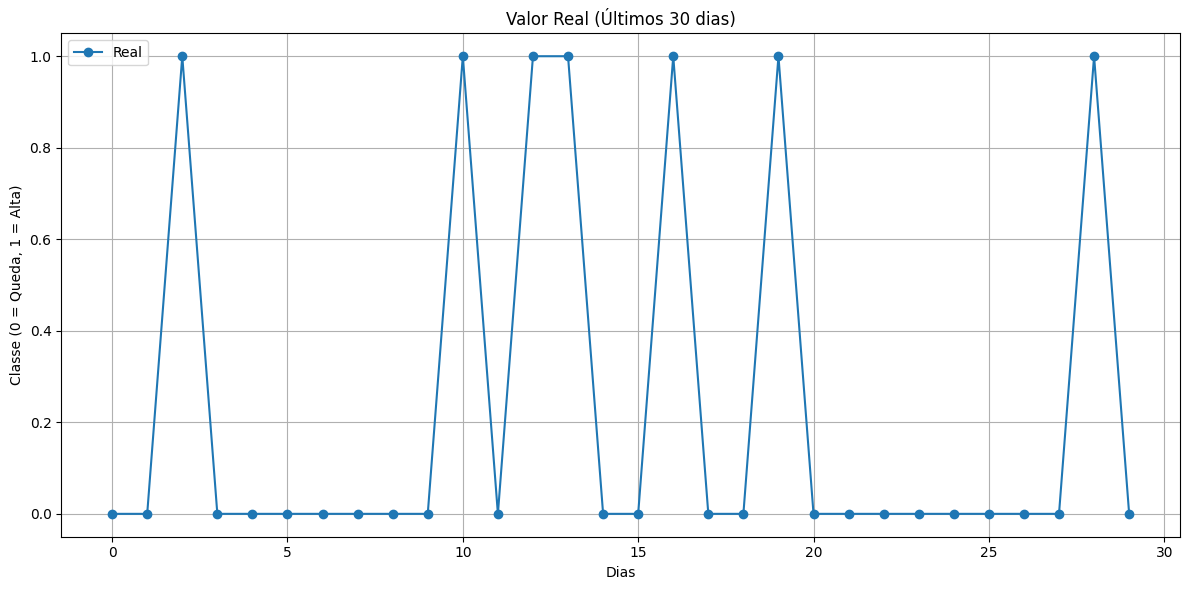

In [461]:
# Plotando valores reais (30 dias)

plt.figure(figsize=(12,6))
plt.plot(y_test_4.reset_index(drop=True), label='Real', marker='o')
plt.title('Valor Real (Últimos 30 dias)')
plt.xlabel('Dias')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

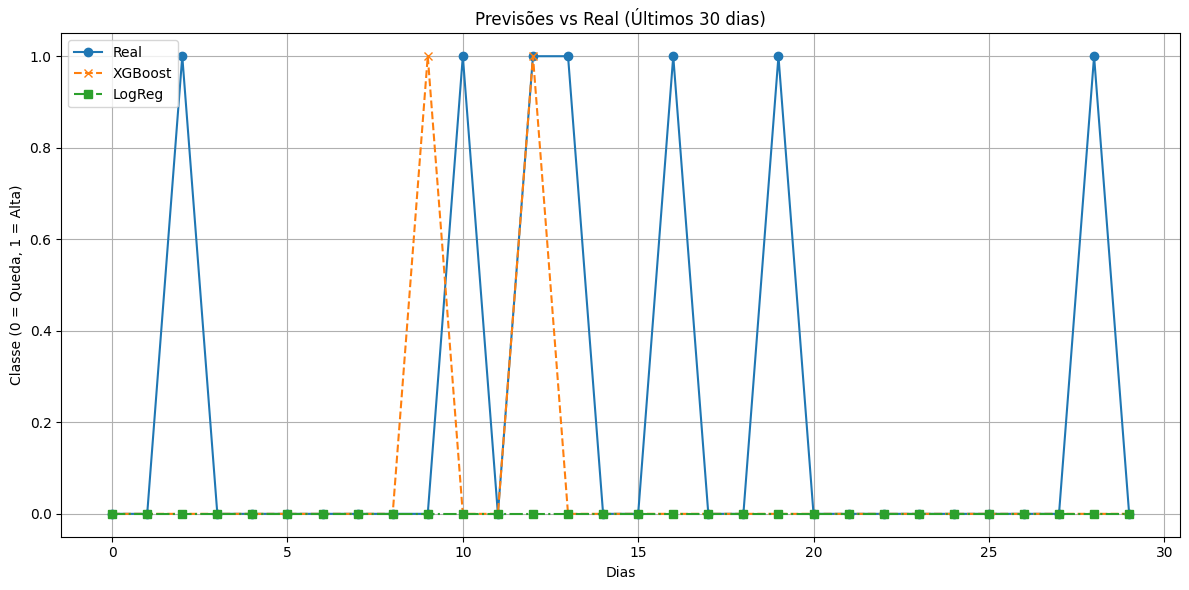

In [462]:
# Plotando previsões vs real (30 dias)

plt.figure(figsize=(12,6))
plt.plot(y_test_4.reset_index(drop=True), label='Real', marker='o')
plt.plot(pd.Series(y_pred_xgb, index=y_test_4.index).reset_index(drop=True), label='XGBoost', linestyle='--', marker='x')
plt.plot(pd.Series(y_pred, index=y_test_4.index).reset_index(drop=True), label='LogReg', linestyle='-.', marker='s')
plt.title('Previsões vs Real (Últimos 30 dias)')
plt.xlabel('Dias')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Criando a coluna de fechamento original
fechamento_original = df['Último'].loc[y_test_4.index]

# Criando dataframe de resultados com as setas (alta e queda)
df_resultados = pd.DataFrame({
    'Data': y_test_4.index,
    'Fechamento': fechamento_original.values,
    'Tendência': y_pred_xgb  })

# Formatando a data como dd/mm/aaaa
df_resultados['Data'] = pd.to_datetime(df_resultados['Data']).dt.strftime('%d/%m/%Y')
df_resultados.set_index('Data', inplace=True)

# Função para aplicar as setas com cor
def formatar_tendencia(valor):
    if valor == 1:
        return '<span style="color:green; font-weight:bold;">▲</span>'
    else:
        return '<span style="color:red; font-weight:bold;">▼</span>'

In [464]:
# Aplicando o estilo corretamente
styled_resultados = df_resultados.style\
   .format({'Tendência': formatar_tendencia}, escape="html")\
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', '#333'), ('font-size', '14pt'), ('text-align', 'center'), ('margin-bottom', '10px')]},
        {'selector': 'th',
         'props': [('background-color', '#f2f2f2'), ('text-align', 'center')]},
        {'selector': 'td',
         'props': [('text-align', 'center')]}
    ])

# Exibir (em notebook)
styled_resultados

,Fechamento,Tendência
Data,,
12/09/2025,142.272000,▼
15/09/2025,143.547000,▼
16/09/2025,144.062000,▼
17/09/2025,145.594000,▼
18/09/2025,145.499000,▼
19/09/2025,145.865000,▼
22/09/2025,145.109000,▼
23/09/2025,146.425000,▼
24/09/2025,146.492000,▼
